In [1]:
from itertools import cycle
from glob import glob
from typing import Union, Tuple, List
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow, Rectangle, Polygon, Circle
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import PolyCollection
import matplotlib.colors as mcolors

import numpy as np
from numpy.typing import ArrayLike, NDArray
from pandas.core.window import rolling
from pycocotools import coco
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import load_img
import pprint as pp

from src.utils.box_cutter import BoundingBox_Processor
from src.utils.classes import CategoricalDataGen
from src.utils.data_worker import LabelWorker
from src.utils.funcs import *

2023-01-22 17:43:02.863116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 17:43:03.068767: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
%aimport src.utils.funcs
%aimport src.utils.box_cutter
%aimport src.utils.classes
%aimport src.utils.data_worker

In [4]:
pp.PrettyPrinter(indent=4)

In [5]:
data = init_COCO("./data/", ['train', 'val', 'test'])
box_cutter = BoundingBox_Processor()

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


In [6]:
labeler = LabelWorker(data_name='train',
                      coco_obj=data,
                      image_path='./data/images/',
                      input_size=(1440, 1920),
                      target_size=(384, 512))

In [7]:
num_anchors = 9

In [10]:
labels = labeler.label_list()[:16]
anchors = stack_anchors(generate_anchors(labels, boxes_per_cell=num_anchors, random_state=42))
label_corners = get_corners(labels)
anchor_corners = get_corners(anchors)
label_edges = get_edges(label_corners)
anchor_edges = get_edges(anchor_corners)
print(f"labels shape: {labels.shape}")
print(f"label_corners shape: {label_corners.shape}")
print(f"label_edges shape: {label_edges.shape}")
print(f"anchors shape: {anchors.shape}")
print(f"anchor_corners shape: {anchor_corners.shape}")
print(f"anchor_edges shape: {anchor_edges.shape}")

labels shape: (16, 12, 9, 19)
label_corners shape: (16, 108, 4, 2)
label_edges shape: (16, 108, 4, 2, 2)
anchors shape: (16, 972, 5)
anchor_corners shape: (16, 972, 4, 2)
anchor_edges shape: (16, 972, 4, 2, 2)


In [ ]:
anchor_edges[0, an::108].shape

In [ ]:
old_corners = box_cutter.get_corners(labels)[0]
old_anchors = box_cutter.get_corners(anchors)[0]
print(f"old_corners: {old_corners.shape}")
print(f"old_anchros: {old_anchors.shape}")
old_intersections = box_cutter.rolling_intersection(old_corners, old_anchors)[0]
old_intersections.shape

In [9]:
x_points = construct_intersection_vertices(labels, anchors, num_pumps=num_anchors)
print(f"x_points: {x_points.shape}")

x_points: (16, 108, 972, 24, 2)


In [ ]:
an = 9 * 3 + 2
bb = 5

fig, ax = plt.subplots(figsize=(8, 6))
ax.set(
        ylim=[0, 384],
        xlim=[0, 512],
        xticks=list(range(0, 512,int(np.ceil(512/12)))),
        yticks=list(range(0, 384, int(np.ceil(384/9)))),
        )
lines = []
points = []
for i in range(num_anchors * 24):
    point = tf.reshape(x_points[0, bb, an::108], [num_anchors * 24, 2])[i]
    if point[0] == 0:
        continue
    points.append(Circle(point, radius=2, color="tomato", zorder=10))
for i in range(1, 12, 1):
    line = i * 512/12
    lines.append([(line, 0), (line, 384)])
for i in range(1, 9, 1):
    line = i * 384/9
    lines.append([(0, line), (512, line)])
grid_lines = mpl.collections.LineCollection(lines, colors='black', lw=1, alpha=1, zorder=200)
ax.add_collection(grid_lines)
ax.add_collection(mpl.collections.LineCollection(label_edges[0, bb]))
ax.add_collection(mpl.collections.LineCollection(anchor_edges[0, an::108].numpy().reshape(num_anchors * 2, 4, 2), color="springgreen"))
ax.add_collection(mpl.collections.PatchCollection(points, color='tomato', alpha=1, zorder=250))
plt.show()

In [ ]:
all_boxes = np.full((1, 108, 1, 4, 2, 2), arr, dtype=np.float32)
all_boxes.shape

In [21]:
color = cycle(["orange", "crimson", "tomato",
               "springgreen", "aquamarine", 
               "fuchsia", "deepskyblue", 
               "mediumorchid", "gold"])
images = sorted(glob("./data/images/train/*"))

In [246]:
label_edges[0, 0].shape

(4, 2, 2)

(4, 2, 2)
(4, 2, 2)
(4, 2, 2)
(4, 2, 2)
(4, 2, 2)
(4, 2, 2)
(4, 2, 2)
(4, 2, 2)
(4, 2, 2)
(4, 2, 2)


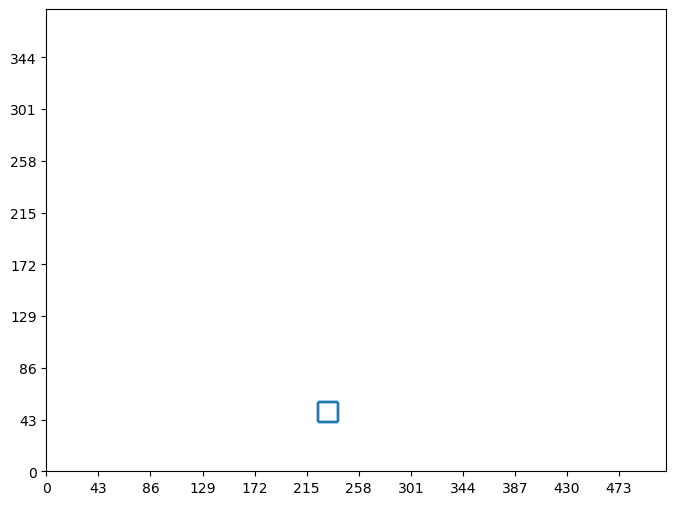

In [267]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set(
        ylim=[0, 384],
        xlim=[0, 512],
        xticks=list(range(0, 512,int(np.ceil(512/12)))),
        yticks=list(range(0, 384, int(np.ceil(384/9)))),
        )
lines = []
for i in range(1, 12, 1):
    line = i * 512/12
    lines.append([(line, 0), (line, 384)])
for i in range(1, 9, 1):
    line = i * 384/9
    lines.append([(0, line), (512, line)])
grid_lines = mpl.collections.LineCollection(lines, colors='black', lw=1, alpha=1, zorder=200)
ax.add_collection(grid_lines)
for i in range(24):
    ax.add_collection(mpl.collections.LineCollection(step2[0, 0, i]))
for i in range(9):
    ax.add_collection(mpl.collections.LineCollection(anchr_edges[0, i:108:9].numpy().reshape(24, 4, 2), color="springgreen"))
    # ax.add_collection(mpl.collections.LineCollection(anchr_edges[0, i+108:216:9].numpy().reshape(24, 4, 2), color="tomato"))
    # ax.add_collection(mpl.collections.LineCollection(anchr_edges[0, i+216:324:9].numpy().reshape(24, 4, 2), color="orange"))
# plt.savefig("./images/anchor_box_illustration.png")
plt.show()

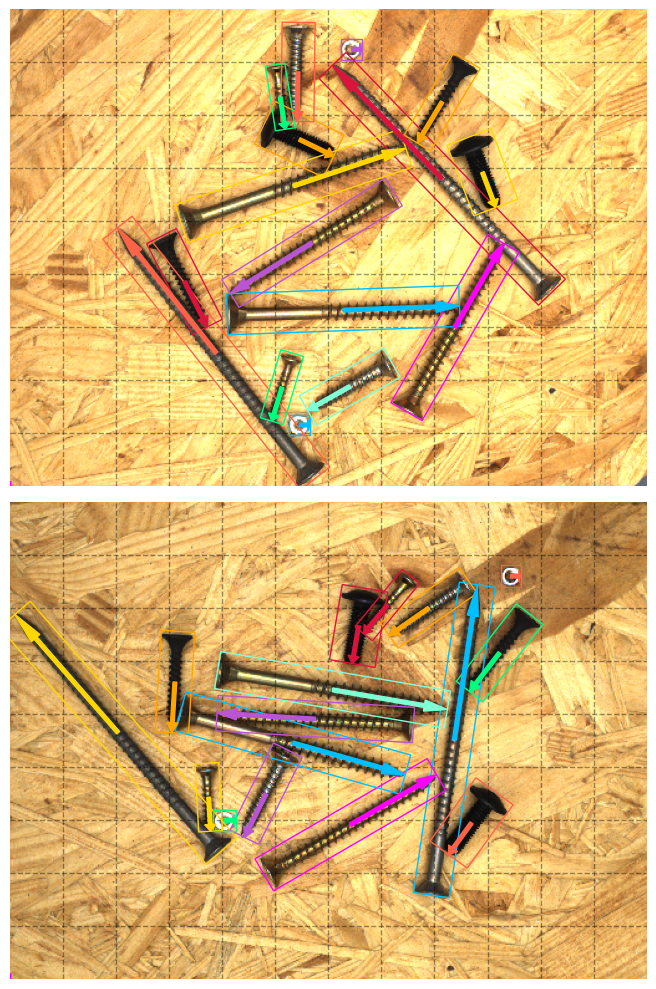

In [129]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
# axs = np.concatenate([ax1, ax2], axis=-1)
for img, ax in enumerate(axs):
    lines = []
    for i in range(1, 12, 1):
        line = i * 512/12
        lines.append([(line, 0), (line, 384)])
    for i in range(1, 9, 1):
        line = i * 384/9
        lines.append([(0, line), (512, line)])
    grid_lines = mpl.collections.LineCollection(lines, colors='black', lw=1, ls='--', alpha=.4)
    ax.set(
            ylim=[0, 384],
            xlim=[0, 512],
            xticks=list(range(0, 512,int(np.ceil(512/12)))),
            yticks=list(range(0, 384, int(np.ceil(384/9)))),
            )
    ax.axis('off')
    ax.imshow(load_img(images[img], target_size=(384, 512)))
    ax.add_collection(grid_lines)
    for idx, box in enumerate(label_corners[img]):
        bbox, arrow = display_label(np.reshape(labels, (labels.shape[0],) + (12 * 9, labels.shape[-1]))[img, idx, 14:], ax, color=next(color))
        ax.add_patch(bbox)
        ax.add_patch(arrow)
        # ax.add_patch(Polygon(label_corners.reshape(269, 12 * 9, 4, 2)[img, idx], fill=None, edgecolor="tomato", lw=5))
fig.tight_layout()
plt.savefig("./images/bounding_box_examples_2.png")
plt.show()

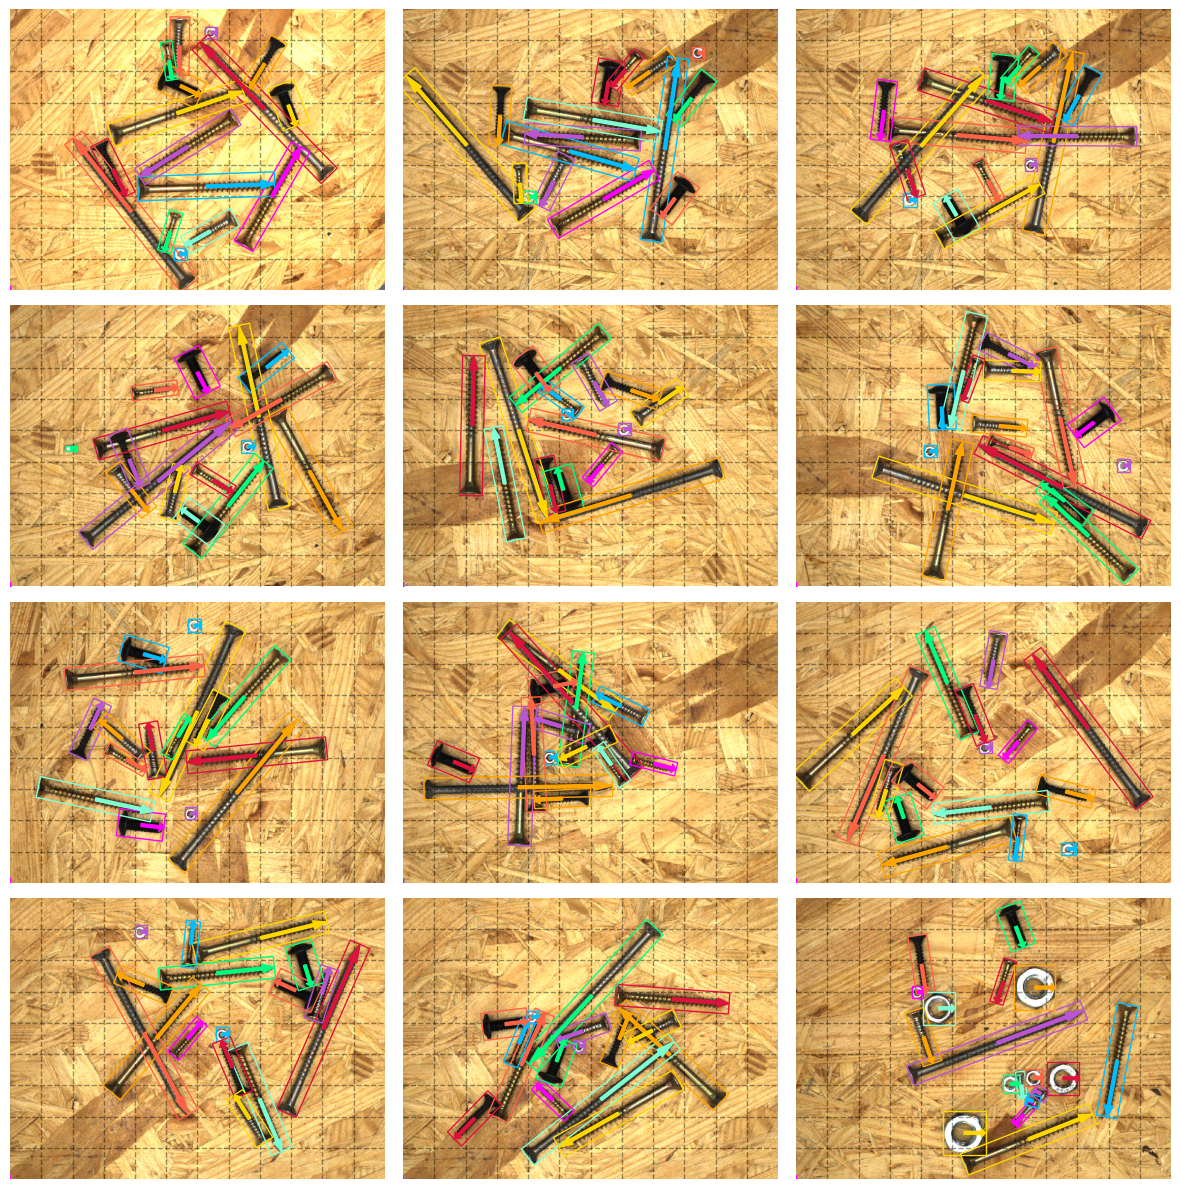

In [119]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 3, figsize=(12, 12))
axs = np.concatenate([ax1, ax2, ax3, ax4], axis=-1)
for img, ax in enumerate(axs):
    lines = []
    for i in range(1, 12, 1):
        line = i * 512/12
        lines.append([(line, 0), (line, 384)])
    for i in range(1, 9, 1):
        line = i * 384/9
        lines.append([(0, line), (512, line)])
    grid_lines = mpl.collections.LineCollection(lines, colors='black', lw=1, ls='--', alpha=.4)
    ax.set(
            ylim=[0, 384],
            xlim=[0, 512],
            xticks=list(range(0, 512,int(np.ceil(512/12)))),
            yticks=list(range(0, 384, int(np.ceil(384/9)))),
            )
    ax.axis('off')
    ax.imshow(load_img(images[img], target_size=(384, 512)))
    ax.add_collection(grid_lines)
    for idx, box in enumerate(label_corners[img]):
        bbox, arrow = display_label(np.reshape(labels, (labels.shape[0],) + (12 * 9, labels.shape[-1]))[img, idx, 14:], ax, color=next(color))
        ax.add_patch(bbox)
        ax.add_patch(arrow)
        # ax.add_patch(Polygon(box, fill=None, edgecolor="tomato", lw=5))
fig.tight_layout()
plt.savefig("./images/bounding_box_examples_16.png")
plt.show()

In [61]:
anchors = generate_anchors(labels, boxes_per_cell=9, random_state=42)
print(f"anchors shape: {anchors.shape}")
batch = anchors.shape[0]
size = anchors.shape[1] * anchors.shape[2]
num_boxes = int((anchors.shape[-1] - 13) / 6)
print(f"num_boxes: {num_boxes}")
a = np.reshape(anchors[..., 13:], (batch, size, num_boxes * 6))
print(f"a.shape: {a.shape}")
print(f"a.strides: {a.strides}")
# a[..., 0:] = np.full(a.shape, np.arange(13, anchors.shape[-1], 1))
print(f"a[0, 0]: {a[0, 0]}")
b = np.expand_dims(a.reshape(batch, size, num_boxes, 6), axis=-2)
print(f"b: {b.shape}")
b = np.reshape(np.transpose(np.full(b.shape[:-2] + (3, b.shape[-1]), b), (0, 2, 1, 3, 4))[..., 0, 1:], (batch, size * num_boxes, 5))
print(f"b: {b.shape}")
print(b[0, 0:108:12])

[[232.65733 274.72534 379.896   232.65733 347.576   165.964   218.8056
  273.18668 357.83466]
 [268.056   242.91786 228.04    347.576   140.31253 231.6312  217.2664
    0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.
    0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.
    0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.
    0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.
    0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.
    0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.
    0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.
    0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.
    0.        0.     ]
 [  0.        0.        0.        0.        0.        0.        0.
    0.        0.     ]
 [

array([[5., 6., 8., 5., 8., 3., 5., 6., 8.],
       [6., 5., 5., 8., 3., 5., 5., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)